In [83]:
import pandas as pd
import datetime
from sklearn.neural_network import MLPClassifier
import random
import torch
from net import gtnet

In [84]:
list_users_above_criteria = [
        1032,
        581,
        407,
        290,
        1436,
        1000,
        95,
        1386,
        1431,
        992,
        1717,
        1441,
        122,
        977,
        293,
        1700,
        1744,
        622,

        192,
        1373,
        84,
        1393,
        1432,
        1378,
        225,
        1753,
        2084,
        969,
        280,
        99,
        53,
        983,
        2068,
        193,
        2056,
        2016,
        2109, 
        1995,
        1706,
        2015,
        186,
        137,
        1658,
        2083,
        1383,
        429,
        279]

In [85]:
seq_len = 14
selected_user = 1032
# 1431 and 95 have bug, excluded for now
user_lst = list_users_above_criteria
def match_dataset_date(selected_user, seq_len, classify_user=False):
    y_df = pd.read_csv(f'/mnt/results/user_{selected_user}_puqe.csv')
    x_df = pd.read_csv(f'/mnt/results/user_{selected_user}_activity_bodyport_hyperimpute_with_date.csv')
    y_df['date'] = pd.to_datetime(y_df['date'])
    x_df['date'] = pd.to_datetime(x_df['date'])
    dataset = []
    for i in range(len(y_df)):
        row = y_df.iloc[i]
        day_before = row['date'] - datetime.timedelta(days=seq_len)
        x = (x_df[(x_df['date'] > day_before) & (x_df['date'] <= row['date'])])
        if classify_user:
            dataset.append((x.drop('date', axis=1).to_numpy(), selected_user))
        else:
            dataset.append((x.drop('date', axis=1).to_numpy(), row['answer_text']))
    return dataset
# gnn_dataset_1032 = match_dataset_date(selected_user, seq_len)
# gnn_dataset_1032 = list(filter(lambda x: len(x[0])>=seq_len, gnn_dataset))
# baseline_dataset_1032 = list(map(lambda x: (x[0][-7:], x[1]), gnn_dataset))
baseline_ds_lst = []
gnn_ds_lst = []
for u in user_lst:
    temp_dataset = match_dataset_date(u, seq_len, classify_user=True)
    temp_dataset = list(filter(lambda x: len(x[0])>=seq_len, temp_dataset))
    gnn_ds_lst.append(temp_dataset)
    baseline_dataset = list(map(lambda x: (x[0][-7:], x[1]), temp_dataset))
    baseline_ds_lst.append(baseline_dataset)
print(len(baseline_ds_lst))
print(len(gnn_ds_lst))

47
47


In [86]:
# # dynamic time warping
# from tslearn.metrics import dtw
# def get_similarities(target_user, user_lst):
#     result = []
#     target_user_df = pd.read_csv(f'/mnt/results/user_{target_user}_activity_bodyport_hyperimpute_with_date.csv').drop('date', axis=1)
#     for user in user_lst:
#         if user == target_user:
#             continue
#         else:
#             curr_user_df = pd.read_csv(f'/mnt/results/user_{user}_activity_bodyport_hyperimpute_with_date.csv').drop('date', axis=1)
#             result.append((user, dtw(target_user_df, curr_user_df)))
#     return sorted(result, key=lambda x: x[1], reverse=True)
# print(get_similarities(290, user_lst))

In [87]:
args = {'data': '/mnt/results/user_456546_activity_bodyport_hyperimpute.csv', 'log_interval': 2000, 'optim': 'adam', 'L1Loss': True, 'normalize': 2, 'device': 'cuda:0', 'gcn_true': True, 'buildA_true': True, 'gcn_depth': 2, 'num_nodes': 19, 'dropout': 0.3, 'subgraph_size': 19, 'node_dim': 40, 'dilation_exponential': 2, 'conv_channels': 16, 'residual_channels': 16, 'skip_channels': 32, 'end_channels': 64, 'in_dim': 1, 'seq_in_len': 14, 'seq_out_len': 1, 'horizon': 7, 'layers': 5, 'batch_size': 32, 'lr': 0.0001, 'weight_decay': 1e-05, 'clip': 5, 'propalpha': 0.05, 'tanhalpha': 3, 'epochs': 50, 'num_split': 1, 'step_size': 100}
device = torch.device(args['device'])
torch.set_num_threads(3)
for i in range(len(user_lst)):
    # model = gtnet(args['gcn_true'], args['buildA_true'], args['gcn_depth'], args['num_nodes'],
    #         device, dropout=args['dropout'], subgraph_size=args['subgraph_size'],
    #         node_dim=args['node_dim'], dilation_exponential=args['dilation_exponential'],
    #         conv_channels=args['conv_channels'], residual_channels=args['residual_channels'],
    #         skip_channels=args['skip_channels'], end_channels= args['end_channels'],
    #         seq_length=args['seq_in_len'], in_dim=args['in_dim'], out_dim=args['seq_out_len'],
    #         layers=args['layers'], propalpha=args['propalpha'], tanhalpha=args['tanhalpha'], layer_norm_affline=False)
    model = torch.load(f'/mnt/results/model/model_{user_lst[i]}.pt')
    model.to(device)
    model.eval()
    for j in range(len(gnn_ds_lst[i])):
        # print(d[0].shape)
        curr = gnn_ds_lst[i][j]
        X = torch.from_numpy(curr[0]).unsqueeze(0).unsqueeze(0).permute(0,1,3,2)
        # print(X.shape)
        X.to(device)
        X = X.type(torch.cuda.FloatTensor)
        out = model(X)
        out = out.squeeze(0).squeeze(0).squeeze(-1)
        gnn_ds_lst[i][j] = out.detach().cpu().numpy(), gnn_ds_lst[i][j][1]


ize([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Size([1, 1, 19, 14])
torch.Si

In [88]:
gnn_ds = []
for ds in gnn_ds_lst:
    gnn_ds.extend(ds)

In [89]:
baseline_ds = []

for ds in baseline_ds_lst:
    baseline_ds.extend(ds)
len(baseline_ds)
random.seed(90)
both_lst = list(zip(baseline_ds, gnn_ds))
random.shuffle(both_lst)
baseline_ds, gnn_ds = zip(*both_lst)

In [90]:
baseline_x = list(map(lambda x: x[0].ravel(), baseline_ds))


baseline_y = list(map(lambda x: x[1], baseline_ds))


cut_pt = int(len(baseline_ds) * 0.8)

baseline_x_train = baseline_x[:cut_pt]
baseline_x_test = baseline_x[cut_pt:]
baseline_y_train = baseline_y[:cut_pt]
baseline_y_test = baseline_y[cut_pt:]

print(len(gnn_ds))
print(len(baseline_ds))

892
892


In [96]:
def analysis_result(x, true, clf, predict_user=False):
    pred = clf.predict(x)
    recall = recall_score(y_true=true, y_pred=pred, average='micro')
    #roc_auc = roc_auc_score(y_true=gnn_y_test, y_score=gnn_y_pred, average='micro', multi_class='ovr')
    precision = precision_score(y_true=true, y_pred=pred, average='micro')
    print(f"Recall: {recall}")
    #print(f"ROC AUC: {roc_auc}")
    print(f"Precision: {precision}")
    cm = confusion_matrix(y_true=true, y_pred=pred)
    classes = ['mild','medium','severe']
    if predict_user:
        classes = list(map(lambda x: str(x), user_lst))
        classes = None
    cm_df = pd.DataFrame(cm,
                        index = classes, 
                        columns = classes)

    #Plotting the confusion matrix
    plt.figure(figsize=(30, 30))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()

In [97]:
clf = MLPClassifier(random_state=90, max_iter=300, hidden_layer_sizes=(50, 15,)).fit(baseline_x_train, baseline_y_train)
clf.score(baseline_x_test, baseline_y_test)


0.0446927374301676

Recall: 0.0446927374301676
Precision: 0.0446927374301676


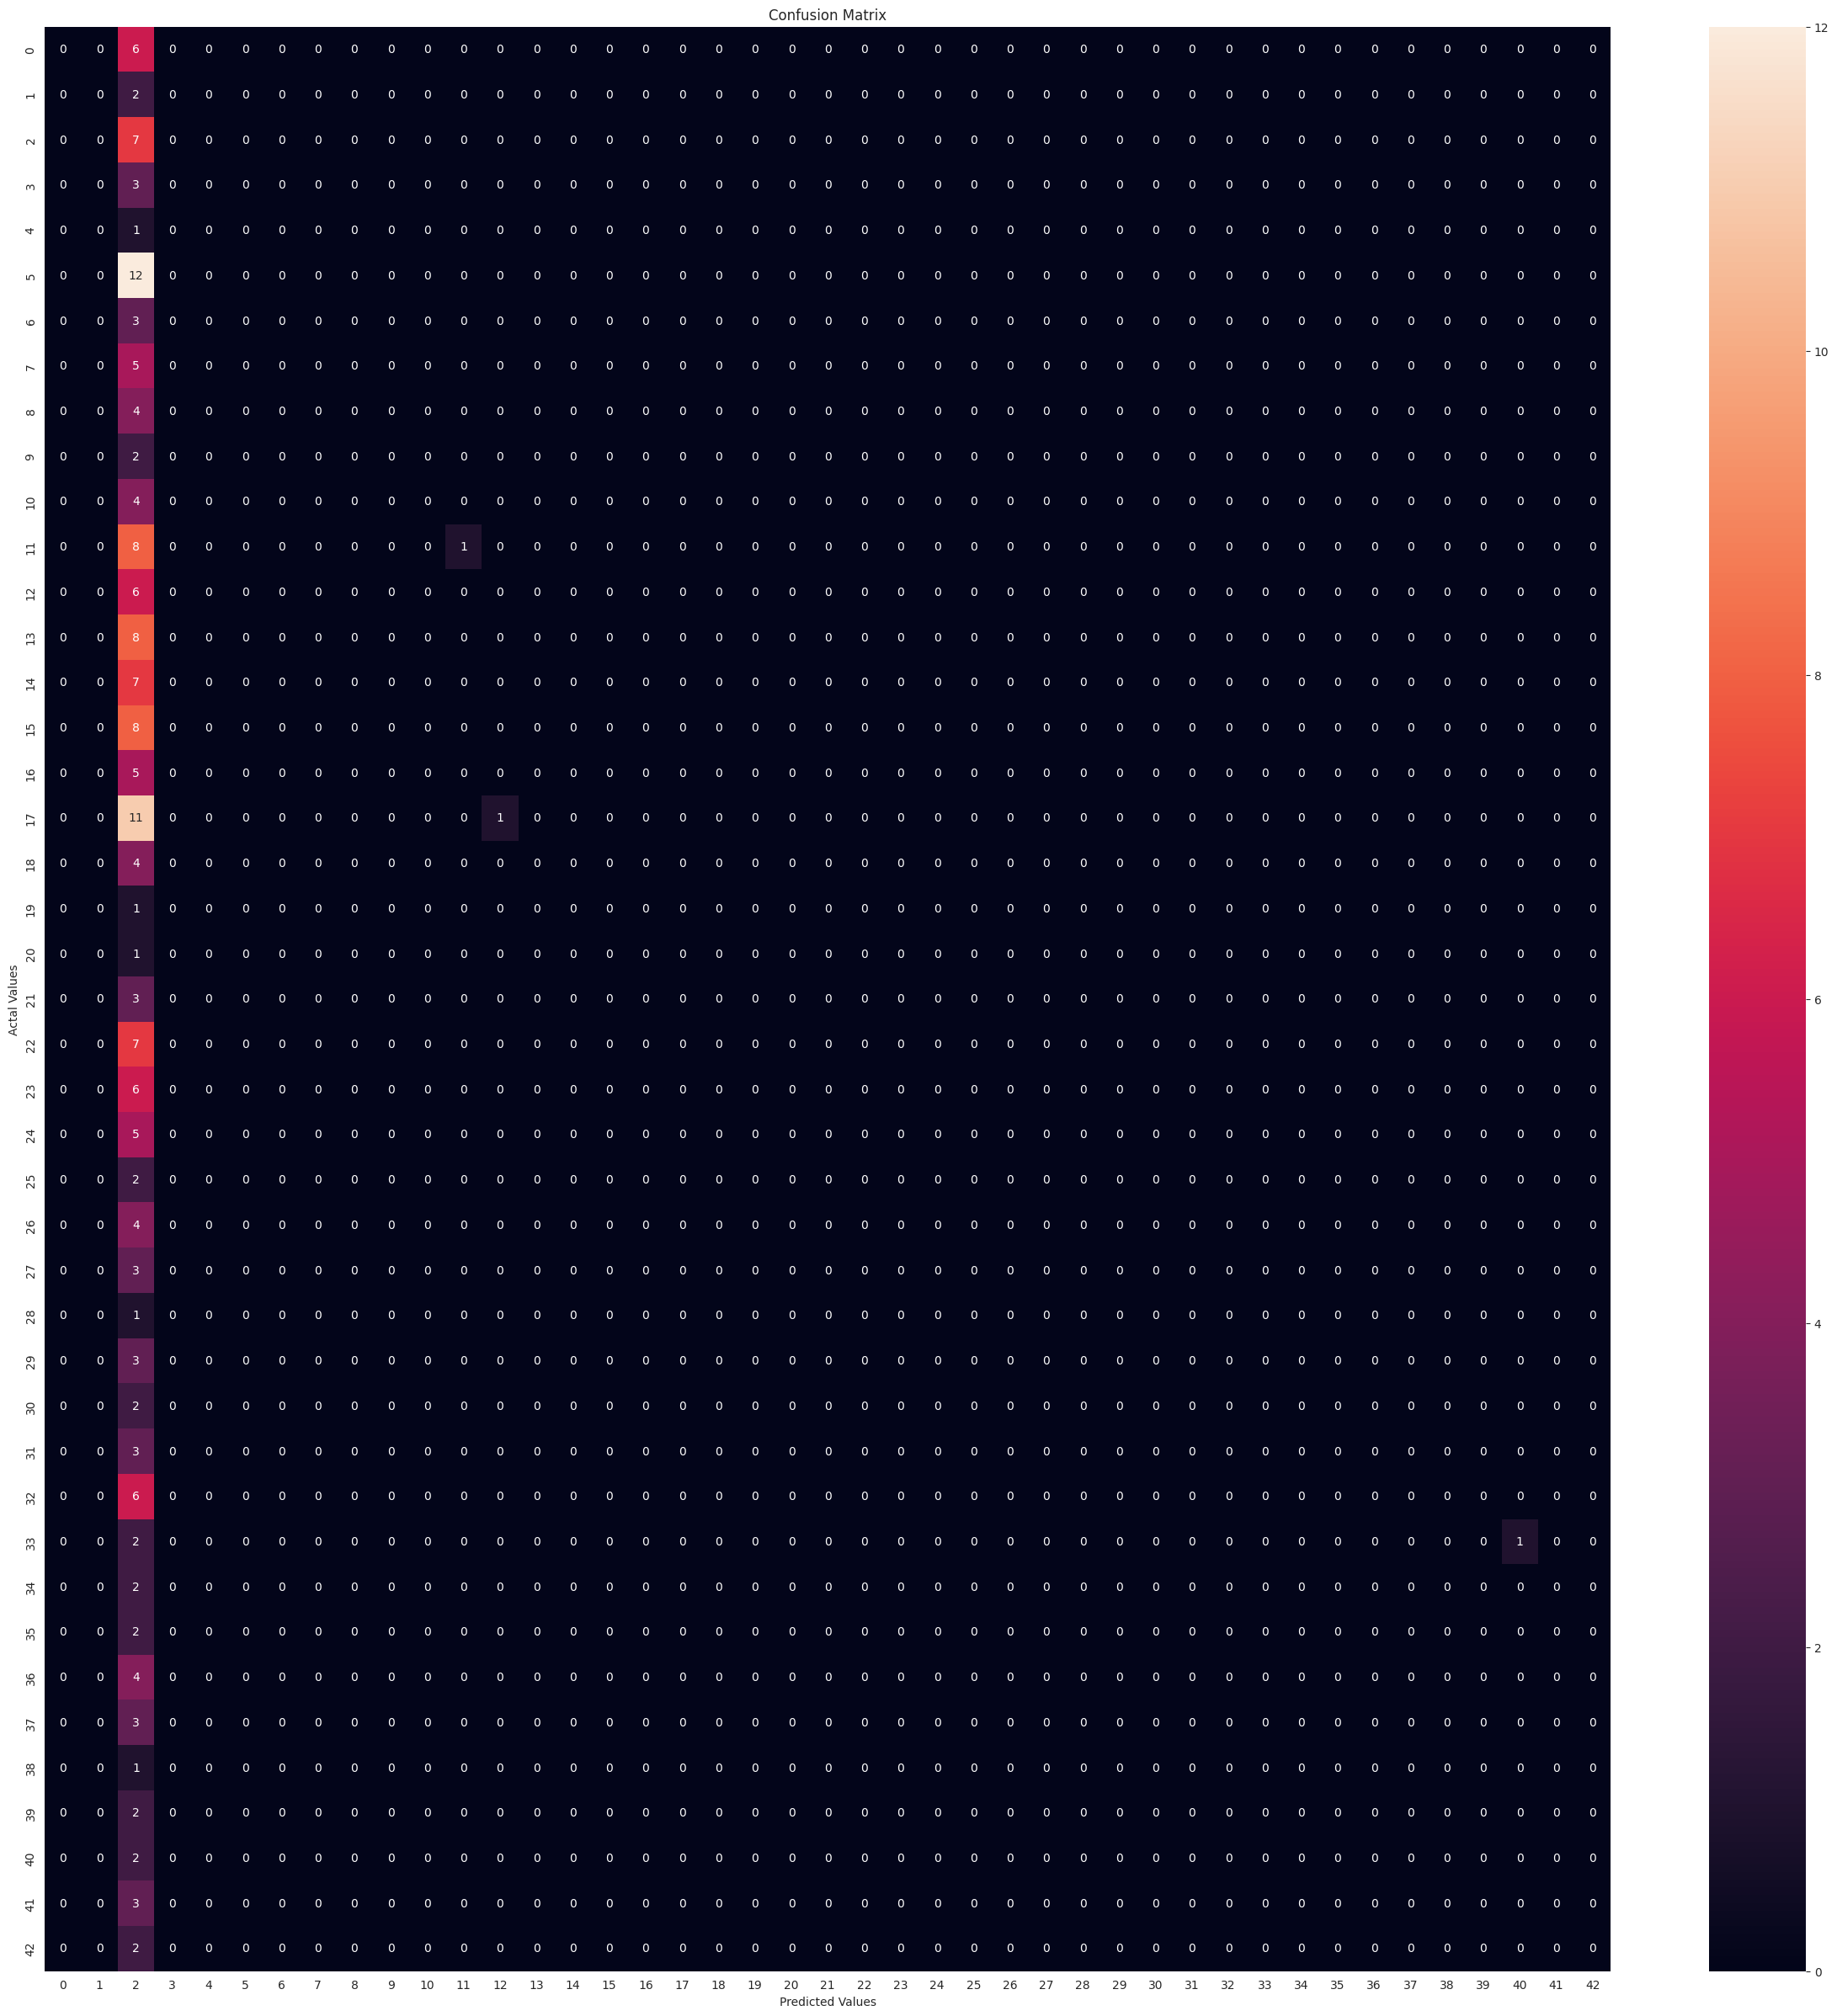

In [98]:
analysis_result(baseline_x_test, baseline_y_test, clf, True)

In [99]:
gnn_x = list(map(lambda x: x[0], gnn_ds))
gnn_y = list(map(lambda x: x[1], gnn_ds))
gnn_x_train = gnn_x[:cut_pt]
gnn_x_test = gnn_x[cut_pt:]
gnn_y_train = gnn_y[:cut_pt]
gnn_y_test = gnn_y[cut_pt:]
clf = MLPClassifier(random_state=90, max_iter=300, hidden_layer_sizes=(40,8,)).fit(gnn_x_train, gnn_y_train)
clf.score(gnn_x_test, gnn_y_test)

0.5810055865921788

Recall: 0.5810055865921788
Precision: 0.5810055865921788


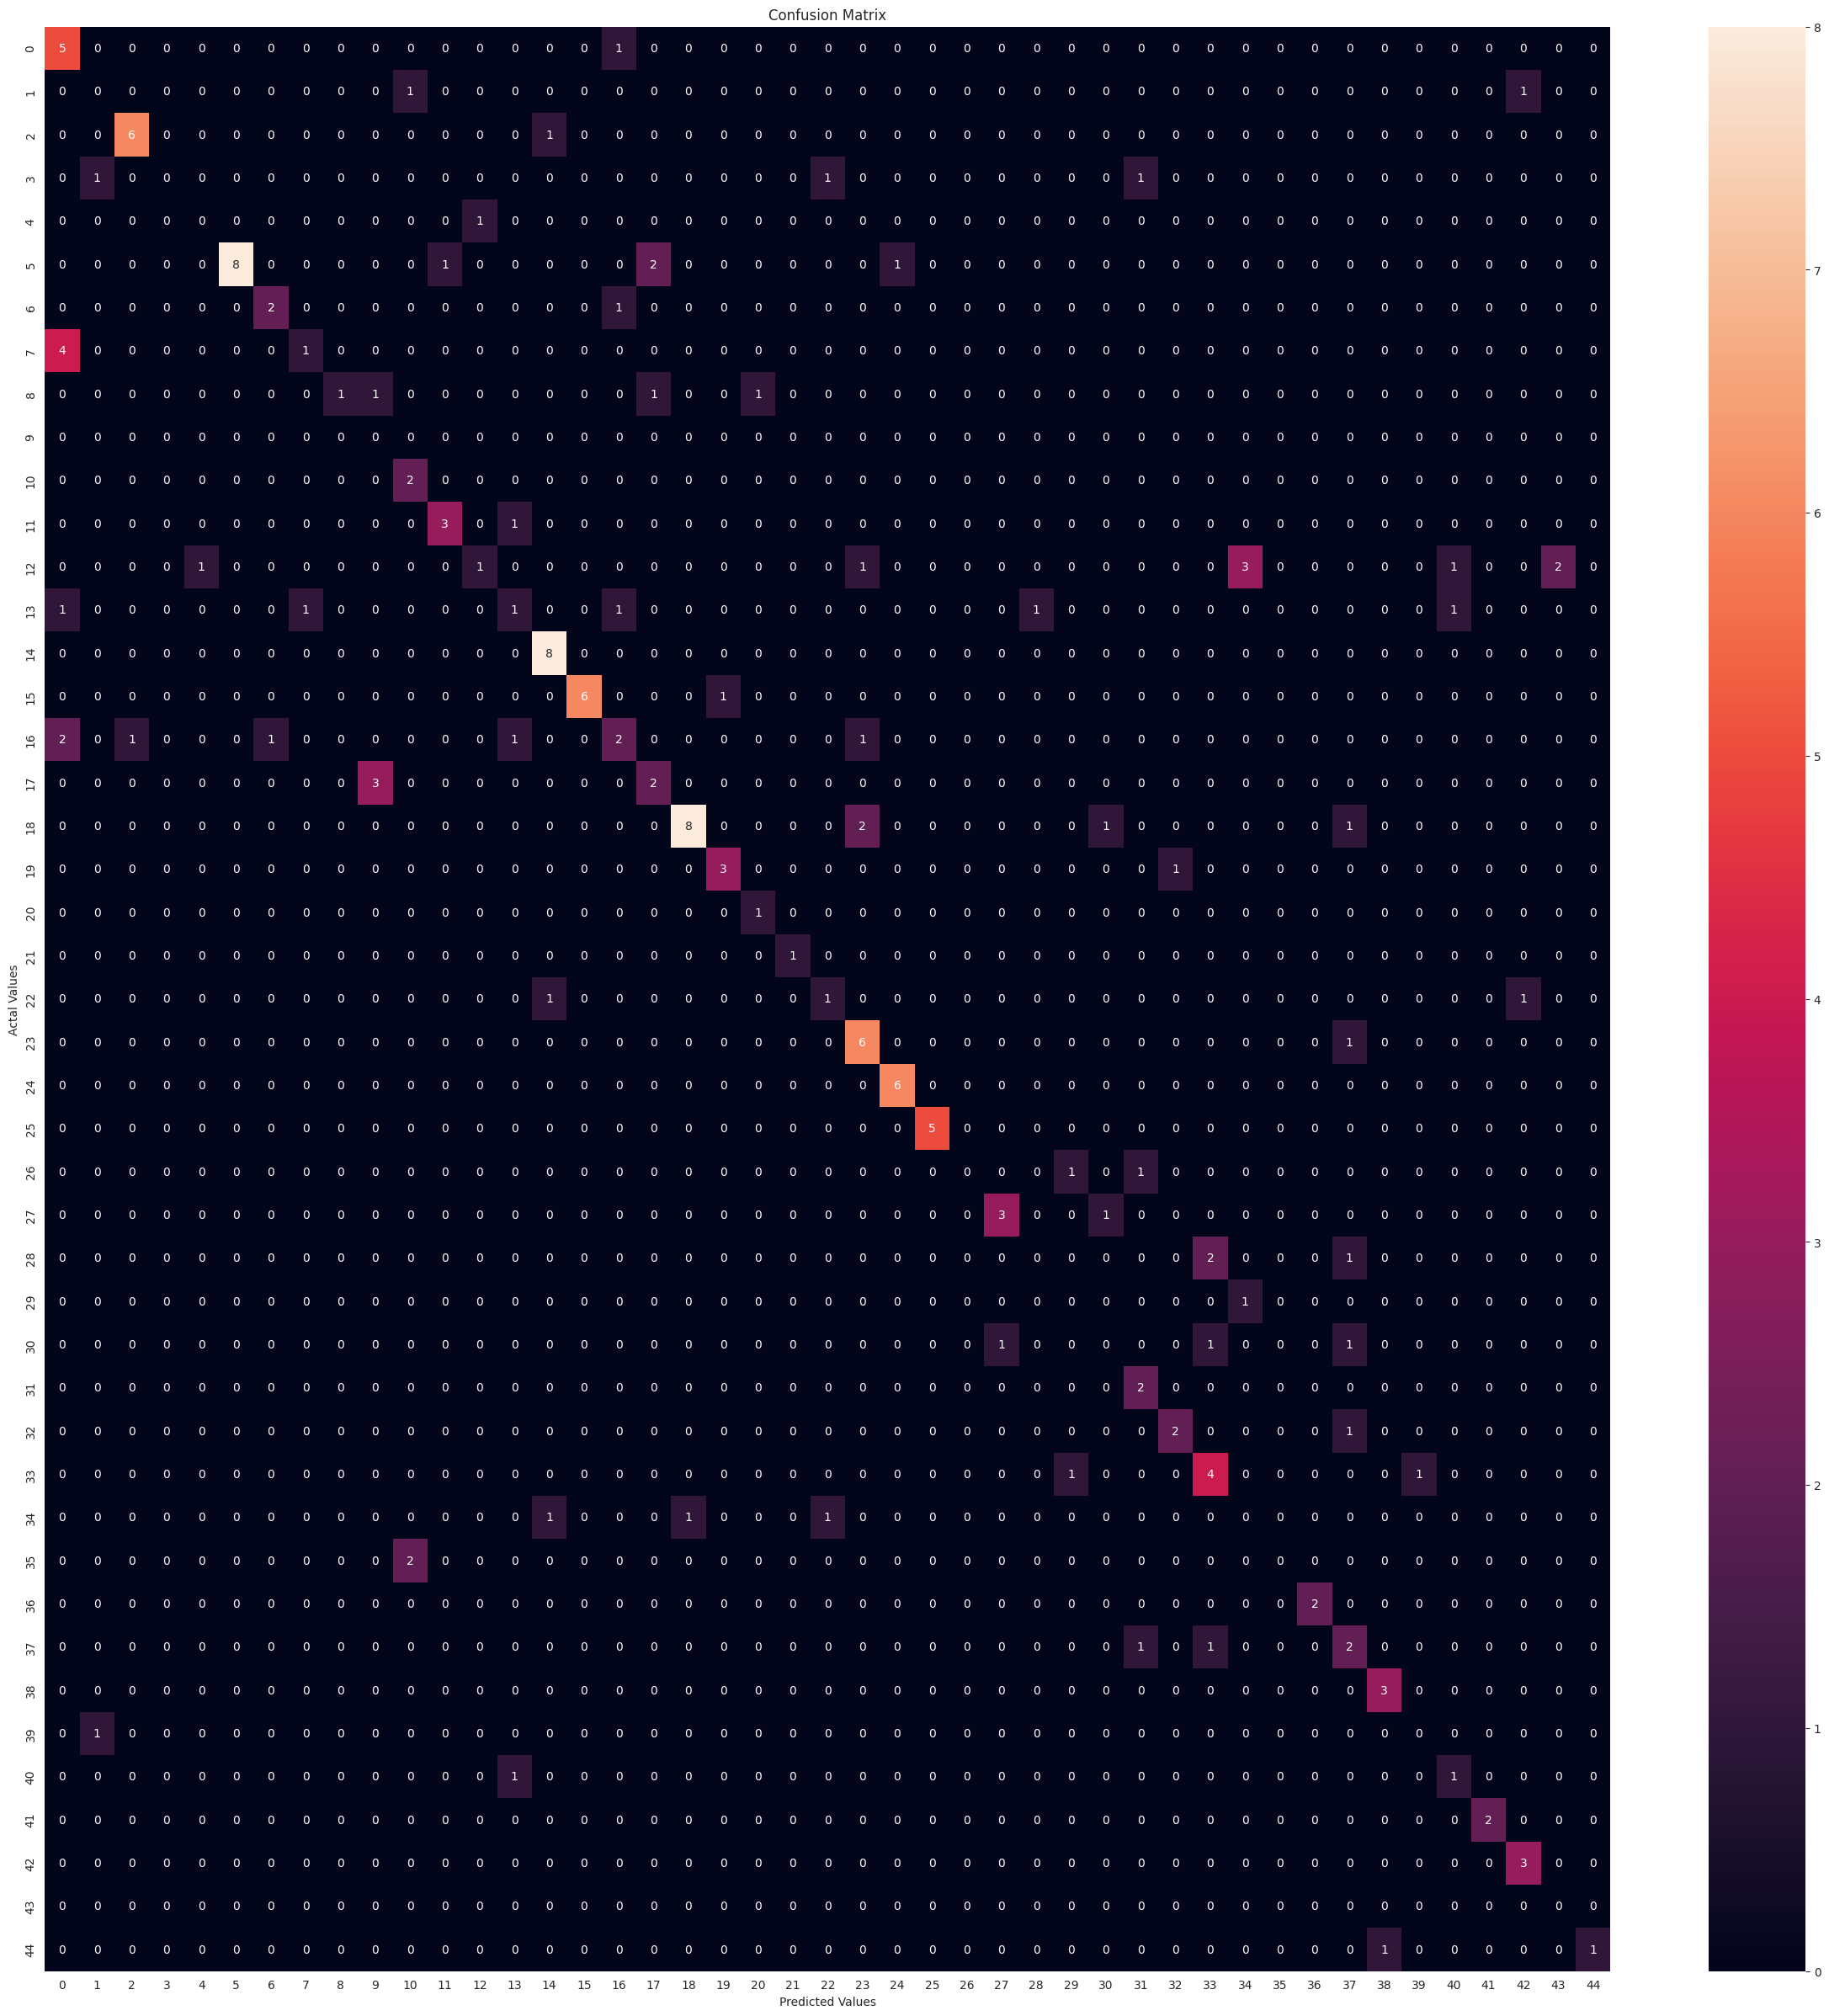

In [100]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

analysis_result(gnn_x_test, gnn_y_test, clf, True)